In [75]:
from google.colab import auth
import gspread
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
auth.authenticate_user()
from google.auth import default
creds, _ = default()
client = gspread.authorize(creds)

In [2]:
!pip install squarify
import squarify

In [3]:
sheet_id = '1wz7Q_Lgk5ni5Wo8ndLhN3pgfcmJ6UZK-qh4dYBmTAfE'
spreadsheet = client.open_by_key(sheet_id)
worksheet = spreadsheet.worksheet("dados")
dados = pd.DataFrame(worksheet.get_all_records())


In [4]:
print(dados.head())

      mes/ano                                              livro  \
0  01/01/2024                      A insustentavel leveza do ser   
1  01/05/2024  Estatistica: o que é, para que serve e como fu...   
2  01/04/2024                      Mude de horario, mude de vida   
3  01/01/2024                         Rita lee uma autobiografia   
4  01/01/2024                       Rita lee outra autobiografia   

              autor      genero       tipo  
0     Milan Kundera      Ficção     kindle  
1   Charles Wheelan     Técnico     fisico  
2  Suhas Kshirsagar  Não-ficção     fisico  
3          Rita Lee   Biografia  audiobook  
4          Rita Lee   Biografia  audiobook  


In [5]:
dados['mes/ano'] = pd.to_datetime(dados['mes/ano'], format='%d/%m/%Y')

In [6]:
print(dados.describe())

                   mes/ano
count                   27
mean   2024-05-02 18:40:00
min    2024-01-01 00:00:00
25%    2024-02-01 00:00:00
50%    2024-04-01 00:00:00
75%    2024-06-16 00:00:00
max    2024-12-01 00:00:00


Estatisticas descritivas / discovery


In [7]:
print(dados.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   mes/ano  27 non-null     datetime64[ns]
 1   livro    27 non-null     object        
 2   autor    27 non-null     object        
 3   genero   27 non-null     object        
 4   tipo     27 non-null     object        
dtypes: datetime64[ns](1), object(4)
memory usage: 1.2+ KB
None


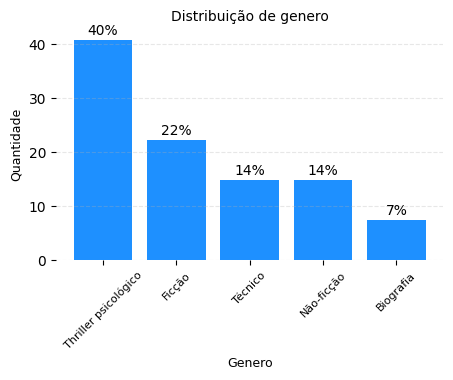

In [8]:
genero_count = dados['genero'].value_counts(normalize=True) * 100
plt.figure(figsize=(5, 3))
plt.bar(genero_count.index, genero_count.values, color= 'dodgerblue')
plt.title('Distribuição de genero', fontsize=10)
plt.xlabel('Genero', fontsize=9)
plt.ylabel('Quantidade', fontsize=9)
plt.xticks(rotation = 45, fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.box(False)

for i, value in enumerate(genero_count.values):
    plt.text(i, value + 0.5, f'{int(value)}%', ha='center', va='bottom')

plt.show()

In [9]:
dados['tipo'] = dados['tipo'].str.title()


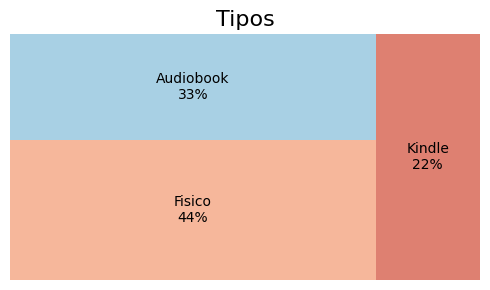

In [10]:
tipo_count = dados['tipo'].value_counts(normalize=True) * 100
labels = [f'{tipo}\n{value:.0f}%' for tipo, value in zip(tipo_count.index, tipo_count.values)]
plt.figure(figsize=(5, 3))
squarify.plot(sizes= tipo_count.values, label= labels, alpha=.8, color=['#f4a582', '#92c5de', '#d6604d'])

plt.title('Tipos', fontsize=16)
plt.xlabel('Tipo', fontsize=10)
plt.ylabel('Quantidade', fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.3)

plt.axis('off')
plt.tight_layout()
plt.show()

In [45]:
mensal = dados.groupby(dados['mes/ano'].dt.to_period('M'))['livro'].count()

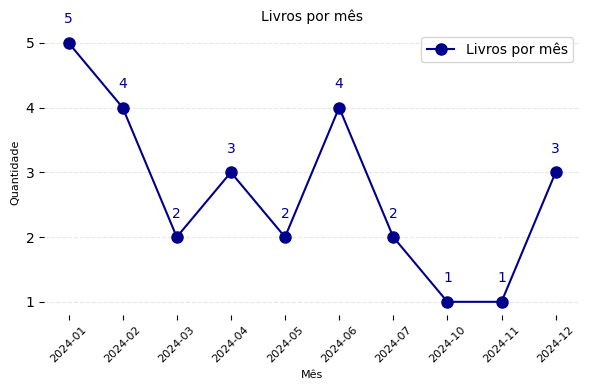

In [12]:
plt.figure(figsize=(6,4))
plt.plot(
    mensal.index.astype(str),
    mensal.values,
    marker = 'o',
    markersize=8,
    linestyle = '-',
    color='darkblue',
    label='Livros por mês'
)
plt.title('Livros por mês', fontsize=10)
plt.xlabel('Mês', fontsize=8)
plt.ylabel('Quantidade', fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.xticks(rotation=45, fontsize=8)
plt.legend()

plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

for i, value in enumerate(mensal.values):
     plt.text(i, value + 0.3, str(value), ha='center', fontsize=10, color='darkblue')

plt.gca().set_facecolor('#f9f9f9')
plt.legend(['Livros por mês'], loc='upper right', fontsize=10)
plt.tight_layout()
plt.box(False)
plt.show()

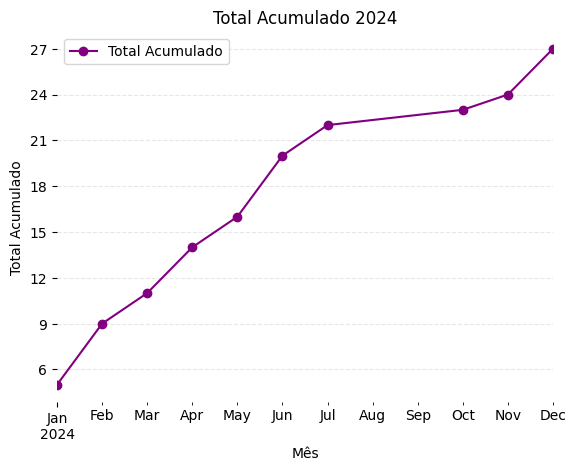

In [13]:
#cumulativo
mensal_cum = mensal.cumsum()

mensal_cum.plot(kind='line', marker='o', color='purple', title='Total Acumulado 2024', label = 'Total Acumulado')
plt.xlabel('Mês')
plt.ylabel('Total Acumulado')
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.box(False)
plt.legend()
plt.show()

In [14]:
dados['mes'] = dados['mes/ano'].dt.month_name()

Analise de correlações

<ipython-input-15-732aee2d469d>:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tabela_genero_mes = dados.pivot_table(


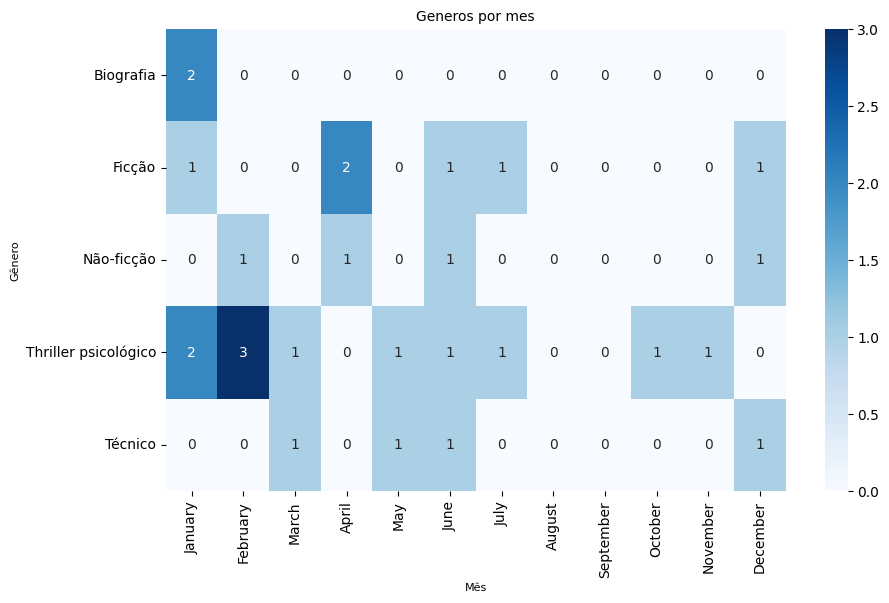

In [15]:
meses_ordem = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
dados['mes'] = pd.Categorical(dados['mes'], categories=meses_ordem, ordered=True)

tabela_genero_mes = dados.pivot_table(
    index='genero',
    columns='mes',
    values='livro',
    aggfunc='count',
    fill_value=0
)

plt.figure(figsize=(10,6))
sns.heatmap(tabela_genero_mes, annot=True, fmt='d', cmap='Blues')
plt.title('Generos por mes', fontsize=10),
plt.xlabel('Mês', fontsize=8)
plt.ylabel('Gênero', fontsize=8)
plt.show()

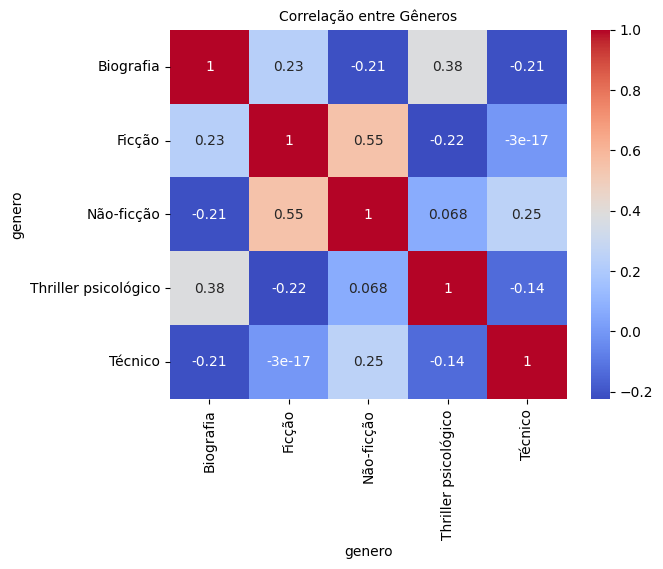

In [16]:
correlacao_mes_genero = tabela_genero_mes.T.corr()
sns.heatmap(correlacao_mes_genero, annot=True, cmap='coolwarm')
plt.title('Correlação entre Gêneros', fontsize=10 )
plt.show()

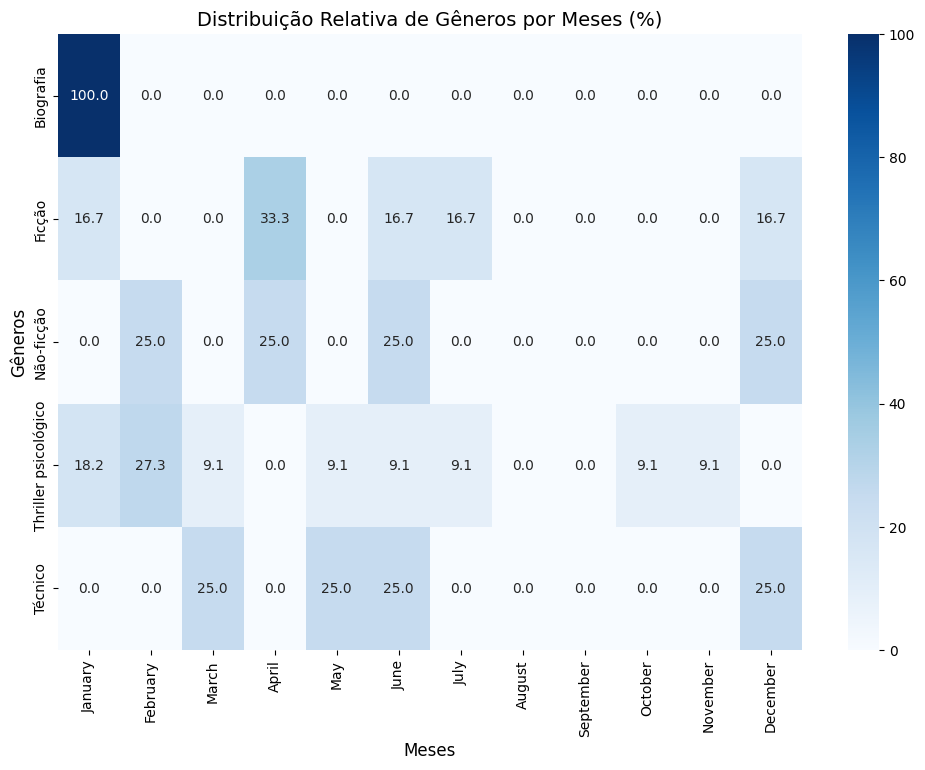

In [17]:
tabela_genero_mes_normalizada = tabela_genero_mes.div(tabela_genero_mes.sum(axis=1), axis=0) * 100
plt.figure(figsize=(12, 8))
sns.heatmap(tabela_genero_mes_normalizada, annot=True, fmt='.1f', cmap='Blues')
plt.title('Distribuição Relativa de Gêneros por Meses (%)', fontsize=14)
plt.xlabel('Meses', fontsize=12)
plt.ylabel('Gêneros', fontsize=12)
plt.show()

In [18]:
scaler = StandardScaler()
tabela_genero_mes_normalizada = scaler.fit_transform(tabela_genero_mes)

tabela_genero_mes_normalizada = pd.DataFrame(tabela_genero_mes_normalizada, columns=tabela_genero_mes.columns, index=tabela_genero_mes.index)
#k-means usa distancia para agrupar os pontos, por isso é necessario normalizar os dados: o fit_transform transforma cada valor de cada coluna pra media 0 e desvio padrao 1.

Aplicando K-means (algoritimo nao supervisionado)

In [19]:
inertia = []
for k in range(1,tabela_genero_mes_normalizada.shape[0]+1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tabela_genero_mes_normalizada)
    inertia.append(kmeans.inertia_)


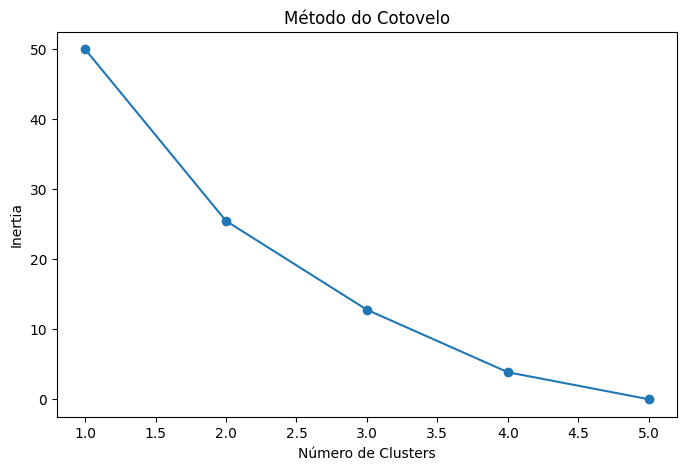

In [20]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(inertia)+1), inertia, 'o-')
plt.xlabel('Número de Clusters')
plt.ylabel('Inertia')
plt.title('Método do Cotovelo')
plt.show()

#cotovelo: ponto de redução significativa da inercia (antes deste ponto, mais cluster melhora a qualidade do agrupamento, após este ponto, pode haver overfitting)
#neste caso dos dados de '24, k se encaixa entre 2 ou 3 (quanto menor a inercia, melhor os dados estão agrupados).
#obs: k-means usa metodo aleatorio pra inicializar os centroides, por isso usa nr randomico (neste caso 42 extraido de uma piada do guia do mochileiro das galaxias ("42 é resposta para vida, universo e td mais"))
# obs2: centroide é o ponto medio de todos os dados de um cluster (se n pontos em um cluster x, é a media das coordenadas de todos estes pontos)

In [21]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(tabela_genero_mes_normalizada)
tabela_genero_mes['clusters'] = clusters

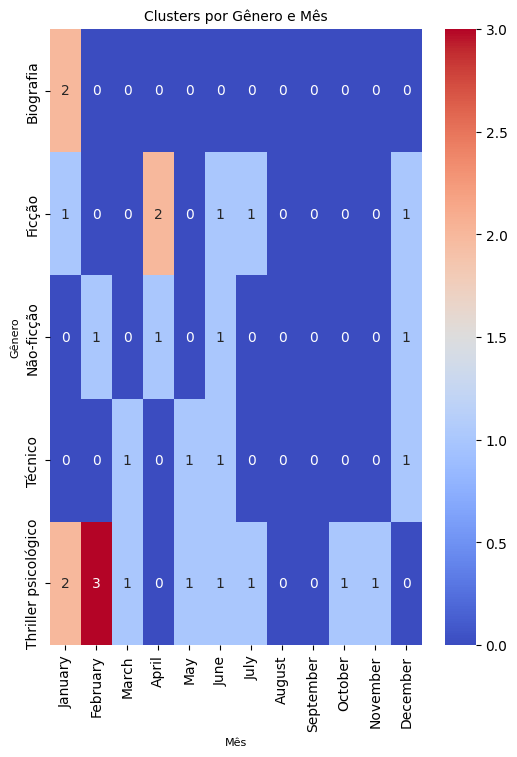

In [22]:
tabela_genero_mes_clusters = tabela_genero_mes.sort_values('clusters')

plt.figure(figsize=(6,8))
sns.heatmap(
    tabela_genero_mes_clusters.drop('clusters', axis=1),
    annot=True,
    cmap='coolwarm'
)
plt.title('Clusters por Gênero e Mês', fontsize=10)
plt.xlabel('Mês', fontsize=8)
plt.ylabel('Gênero', fontsize=8)
plt.show()


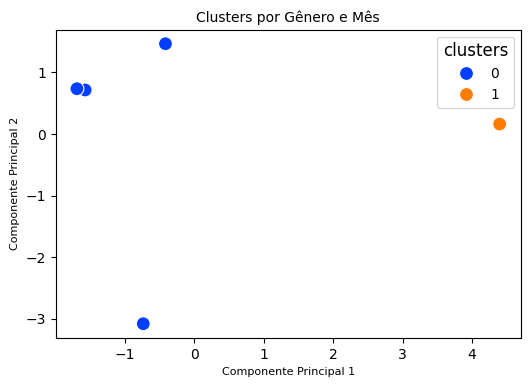

In [23]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tabela_genero_mes_normalizada)

plt.figure(figsize=(6,4))
scatter = sns.scatterplot(
    x=pca_result[:,0],
    y=pca_result[:,1],
    hue=tabela_genero_mes['clusters'],
    palette='bright',
    s=100
)
handles, labels = scatter.get_legend_handles_labels()
plt.legend(title='clusters', fontsize=10, title_fontsize=12, loc='upper right')

plt.title('Clusters por Gênero e Mês', fontsize=10)
plt.xlabel('Componente Principal 1', fontsize=8)
plt.ylabel('Componente Principal 2', fontsize=8)
plt.show()


In [24]:
cluster0 = tabela_genero_mes[tabela_genero_mes['clusters']== 0]
cluster1 = tabela_genero_mes[tabela_genero_mes['clusters']== 1]
print(cluster0)

mes         January  February  March  April  May  June  July  August  \
genero                                                                 
Biografia         2         0      0      0    0     0     0       0   
Ficção            1         0      0      2    0     1     1       0   
Não-ficção        0         1      0      1    0     1     0       0   
Técnico           0         0      1      0    1     1     0       0   

mes         September  October  November  December  clusters  
genero                                                        
Biografia           0        0         0         0         0  
Ficção              0        0         0         1         0  
Não-ficção          0        0         0         1         0  
Técnico             0        0         0         1         0  


In [25]:
print(cluster1)

mes                   January  February  March  April  May  June  July  \
genero                                                                   
Thriller psicológico        2         3      1      0    1     1     1   

mes                   August  September  October  November  December  clusters  
genero                                                                          
Thriller psicológico       0          0        1         1         0         1  


Analise temporal avançada para previsão linear


In [59]:
mensal = mensal.reset_index(drop=True)
print(mensal.columns)
print(mensal.head())

Index(['mes/ano', 'livro'], dtype='object')
   mes/ano  livro
0  2024-01      5
1  2024-02      4
2  2024-03      2
3  2024-04      3
4  2024-05      2


In [68]:
mensal['tempo'] = list(range(1, len(mensal) + 1))
mensal['livro'] = pd.to_numeric(mensal['livro'], errors='coerce')
print(  mensal.head())

     mes/ano  livro  tempo
0 2024-01-01      5      1
1 2024-02-01      4      2
2 2024-03-01      2      3
3 2024-04-01      3      4
4 2024-05-01      2      5


In [69]:
x = sm.add_constant(mensal['tempo'])
y = mensal['livro']
modelo = sm.OLS(y, x).fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                  livro   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     4.927
Date:                Mon, 06 Jan 2025   Prob (F-statistic):             0.0572
Time:                        21:50:41   Log-Likelihood:                -14.171
No. Observations:                  10   AIC:                             32.34
Df Residuals:                       8   BIC:                             32.95
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2000      0.762      5.509      0.0

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)


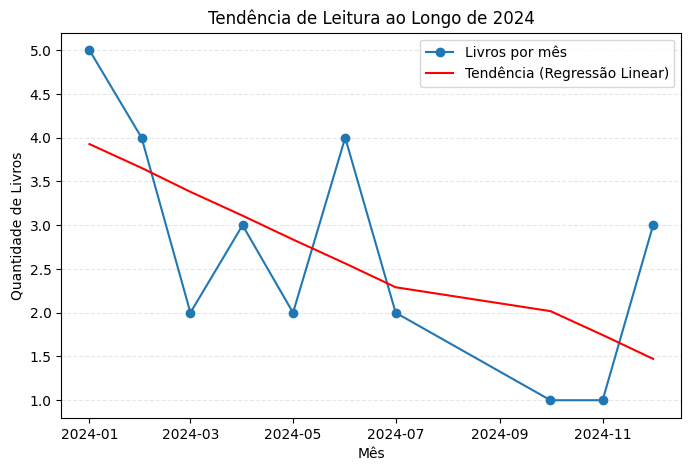

In [74]:
mensal['mes/ano'] = pd.to_datetime(mensal['mes/ano'])

plt.figure(figsize=(8, 5))
plt.plot(mensal['mes/ano'], mensal['livro'], label='Livros por mês', marker='o')
plt.plot(mensal['mes/ano'], modelo.predict(x), label='Tendência (Regressão Linear)', color='red')

plt.title('Tendência de Leitura ao Longo de 2024')
plt.xlabel('Mês')
plt.ylabel('Quantidade de Livros')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()